# 2nd version MNIST CBE-ANN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
Train = False

# Load dataset and model

In [3]:
(ds_test, ds_val, ds_train), ds_info = tfds.load(
    'mnist',
    split=['train[:10%]','train[10%:25%]','train[25%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img)
ds_test = ds_test.map(
    normalize_img)
ds_val = ds_val.map(
    normalize_img)

In [4]:
images_tr = [elem[0] for elem in ds_train.as_numpy_iterator()]
labels = [elem[1] for elem in ds_train.as_numpy_iterator()]
images_tr = np.stack(images_tr)
labels = np.array(labels)

In [5]:
model = tf.keras.models.load_model('../modelmnist')

In [6]:
if Train == True:
    model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    )

In [7]:
image_list = [elem[0] for elem in ds_test.as_numpy_iterator()]
labels_list = [elem[1] for elem in ds_test.as_numpy_iterator()]
image_list = np.stack(image_list)
labels_list = np.array(labels_list)

# Select input

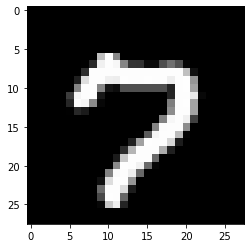

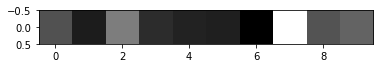

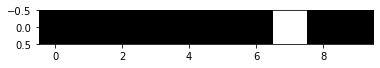

In [8]:
indice_input = 3
inputs = image_list[indice_input]
plt.imshow(inputs, cmap='gray')
plt.show()

inputs = np.expand_dims(inputs,0)
targets = model.predict(inputs)
strict_targets = (targets == np.max(targets)).astype(int)
plt.imshow(targets, cmap='gray')
plt.show()
plt.imshow(strict_targets, cmap='gray')
plt.show()

# Import method

In [9]:
#from CaseBasedExplainer import CaseBasedExplainer
from xplique.plots import plot_attributions
from xplique.plots.image import _standardize_image
from xplique.attributions import Occlusion
from xplique.types import Callable, Tuple, Union, Optional
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KDTree

In [10]:
class CaseBasedExplainer():
    

    def __init__(self,
            model: Callable,
            case_dataset: Union[tf.data.Dataset, tf.Tensor, np.ndarray],
            batch_size: Optional[int] = 16,
            distance_function: DistanceMetric = None,
            weights_extraction_function: Callable = None):
        
        """
        Parameters
        ----------

        model
            The model from wich we want to obtain explanations
        case_dataset
            The dataset used to train the model
        batch_size
            Default = 16
        distance_function
            The function to calcul the distance between two point.
            (Can use : euclidean, manhattan, minkowski etc...)
        weights_extraction_function
            The function to calcul the weight of every features, many type of methode can be use but it will depend of
            what type of dataset you've got.
        """
        self.model = model
        self.batch_size = batch_size
        self.case_dataset = case_dataset
        self.weighted_extraction_function = weights_extraction_function
        y_pred = model.predict(case_dataset)
        case_dataset_weight = self.weighted_extraction_function(case_dataset, y_pred)
        case_dataset_weight = np.expand_dims(case_dataset_weight, 3)
        self.case_dataset_weight = case_dataset_weight
        weighted_case_dataset = tf.math.multiply(case_dataset_weight, case_dataset)
        weighted_case_dataset = tf.reshape(weighted_case_dataset, [weighted_case_dataset.shape[0], -1])
        self.Knn = KDTree(weighted_case_dataset, metric = 'euclidean')

    def explain(self,
                inputs: Union[tf.Tensor, np.ndarray],
                targets: Union[tf.Tensor, np.ndarray]= None,
                k: int = 1):
        
        """
        Parameters
        ----------
        inputs
            Tensor or Array. Input sapmples to be explained.
            Expected shape among (N,T,W), (N,W,H,C).
        
        target
            Tensor or Array. Corresponding to the prediction of the samples by the model.
            shape: (n, nb_classes)
            
        K
            Represante how many nearest neighbours you want to be return.
        
        Returns
        -------
        
        dist
            distance between the input and the k-nearest_neighbours, represented by a float.
            
        ind 
            The index of the k-nearest_neighbours in the dataset.
            
        weight
            ...
        """
        # (n, H, W, D)
        self.inputs = inputs
        weight = self.weighted_extraction_function(inputs, targets)
        weight = np.expand_dims(weight, 3)
        weighted_inputs = tf.math.multiply(weight, inputs)
        weighted_inputs = tf.reshape(weighted_inputs, [weighted_inputs.shape[0], -1])
        dist , ind = self.Knn.query(weighted_inputs, k = k)
        
        #ind =  np.unique(ind)
        ind = ind[0]
        dist = np.unique(dist)
        
        return dist, ind, weight
    
    
    def showResult(self,
                    ind: int,
                    dist: float,
                    weight: np.ndarray,
                    indice_original: int,
                    labels_train: np.ndarray,
                    labels_test: np.ndarray):
        """
        Parameters
        ---------
        ind
            Represente the number of the indice of data in the train dataset
            
        dist
            Represente the distance between input data and the K-nearest_neighbours
            
        weight
            ...
        
        indice_original
            Represente the number of the indice of the inputs to show the true labels
        
        labels_train
            Corresponding to the train labels dataset
            
        lables_test
            Corresponding to the test labels dataset
            
        """
        explains = self.inputs
        weight_tab = weight
        for i in ind:
            case_dataset = np.expand_dims(self.case_dataset[i],0)
            case_dataset_weight = np.expand_dims(self.case_dataset_weight[i], 0)
            explains = tf.concat([explains,case_dataset], axis = 0)
            weight_tab = tf.concat([weight_tab, case_dataset_weight], axis = 0)
        clip_percentile = 0.2
        plt.rcParams["figure.autolayout"] = True
        plt.rcParams["figure.figsize"] = [25, 6]
        fig = plt.figure()
        gs = fig.add_gridspec(2, len(explains)*2)
        for j in  range(len(explains)):
            ax = fig.add_subplot(gs[0,j])
            pred_img = np.expand_dims(explains[j], 0)
            pred_img = self.model.predict(pred_img)
            pred_img = np.argmax(pred_img)
            if j == 0:
                plt.title('Original image\nGT: '+str(labels_test[indice_original])+'\npredict: '+ str(pred_img))
            else:
                plt.title('K-nearest neighbours\nGT: '+str(labels_train[ind[j-1]])+'\npredict: '+ str(pred_img)+ '\ndistance: '+ str(round(dist[j-1],2)))
            plt.imshow(explains[j],cmap = 'gray')
            plt.axis("off")
            ax2 = fig.add_subplot(gs[1,j])
            plt.imshow(explains[j], cmap = "gray")
            plt.imshow(_standardize_image(weight_tab[j], clip_percentile),cmap = "coolwarm", alpha = 0.5)
            plt.axis("off")
        plt.show()

# Use the method

In [11]:
weights_extraction_function = Occlusion(model,patch_size=(4, 4), patch_stride=(2, 2),batch_size=16, occlusion_value=0).explain
distance_function = DistanceMetric.get_metric('euclidean')

explainer = CaseBasedExplainer(model,
                               images_tr[:150],
                               distance_function = distance_function,
                               weights_extraction_function = weights_extraction_function)

C:\Users\adelin.constans\Anaconda3\envs\tfearly\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [12]:
explanation_dist, explanation_id, weight = explainer.explain(inputs, targets,5)
print(explanation_id)
print(explanation_dist)
#print(weight)

[ 96  98 100 141 132]
[3409.17000703 3915.55548938 3954.53627021 4047.12282472 4207.98850208]


# Show Result

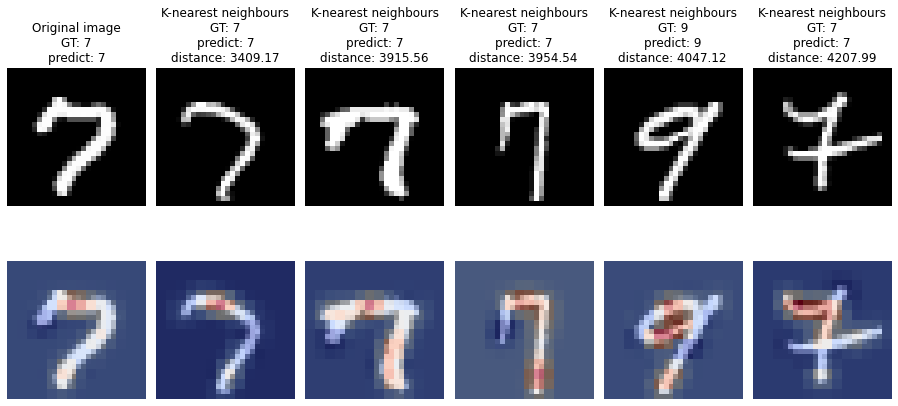

In [13]:
explainer.showResult(explanation_id, explanation_dist, weight, indice_input, labels, labels_list) 